In [1]:
import gymnasium as gym
import numpy as np
import associata

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# RL methods

In [3]:
from abc import ABC, abstractmethod

In [4]:
import time


class TD(ABC):
    def __init__(self, state_space_bounds, state_space_epsilon, action_space, alpha=0.2, gamma=1.0, greedey_epsilon=0.1):
        self._state_space_bounds = state_space_bounds
        self._state_space_epsilon = state_space_epsilon
        self._state_space_shape = np.ceil((state_space_bounds[1, :] - state_space_bounds[0, :]) / state_space_epsilon).astype('int')
        self._action_space = action_space
        
        self._init_q()

        self.greedy_epsilon = greedey_epsilon
        self.alpha = alpha
        self.gamma = gamma

        self._last_state = None
        self._last_action = None
        self._acc_reward = 0.0
        self.episode_rewards = []

        self._step_nr = 0

        self._time_origin = time.time()


    def _timestamp(self):
        return f'[{int(time.time() - self._time_origin)}s]'


    def step(self, observation, reward=None):
        print(f'\n=============== Step {self._step_nr} ===============')

        state = self._get_state(observation)

        print(f'{self._timestamp()} State: {state}\nReward (for prevoius action): {reward}\n')

        action = self._get_action(state)

        print(f'{self._timestamp()} Picked action: {action}')

        if self._last_action is not None and reward is not None:
            self._update_q(state, action, reward)
            self._acc_reward += reward

        self._last_state = state
        self._last_action = action

        self._step_nr += 1

        return action
    

    def reset_episode(self, save_score=True):
        self._last_state = None
        self._last_action = None

        if save_score:
            self.episode_rewards.append(self._acc_reward)
        
        self._acc_reward = 0.0

    @abstractmethod
    def _get_state(self, observation):
        pass

    @abstractmethod
    def _get_action(self, state):
        pass

    @abstractmethod
    def _init_q(self):
        pass

    @abstractmethod
    def _update_q(self, next_state, next_action, reward):
        pass

## Classic

In [6]:
class Sarsa(TD):
    def _get_state(self, observation):
        indices = np.floor((observation - self._state_space_bounds[0, :]) / self._state_space_epsilon)
        return np.clip(indices, np.zeros(len(self._state_space_shape)), self._state_space_shape - 1).astype('int')


    def _get_action(self, state):
        if np.random.random() < self.greedy_epsilon:
            # exploratory action
            return np.array([np.random.choice(self._action_space)])

        else:
            # exploiting action
            action_values = self.q[*state, :]
            max_action_value = np.max(action_values)
            max_actions = np.argwhere(action_values == max_action_value)
            if (len(max_actions) > 1):
                action_index = np.random.randint(max_actions.shape[0])
            else:
                action_index = 0
            return max_actions[action_index]
        

    def _init_q(self):
        self.q = np.zeros(tuple(self._state_space_shape) + self._action_space.shape)


    def _update_q(self, next_state, next_action, reward):
        self.q[*self._last_state, *self._last_action] += self.alpha * (reward + self.gamma * self.q[*next_state, *next_action] - self.q[*self._last_state, *self._last_action])

In [6]:
class QLearning(TD):
    def _get_state(self, observation):
        indices = np.floor((observation - self._state_space_bounds[0, :]) / self._state_space_epsilon)
        return np.clip(indices, np.zeros(len(self._state_space_shape)), self._state_space_shape - 1).astype('int')


    def _get_action(self, state):
        if np.random.random() < self.greedy_epsilon:
            # exploratory action
            return np.array([np.random.choice(self._action_space)])

        else:
            # exploiting action
            action_values = self.q[*state, :]
            max_action_value = np.max(action_values)
            max_actions = np.argwhere(action_values == max_action_value)
            if (len(max_actions) > 1):
                action_index = np.random.randint(max_actions.shape[0])
            else:
                action_index = 0
            return max_actions[action_index]


    def _init_q(self):
        self.q = np.zeros(tuple(self._state_space_shape) + self._action_space.shape)


    def _update_q(self, next_state, _next_action, reward):
        max_q = np.max(self.q[*next_state, :])
        self.q[*self._last_state, *self._last_action] += self.alpha * (reward + self.gamma * max_q - self.q[*self._last_state, *self._last_action])

## Associata

In [5]:
class SarsaAGDS(TD):
    def __init__(self, state_space_feature_names, state_space_bounds, state_space_epsilon, action_space, alpha=0.2, gamma=1.0, greedey_epsilon=0.1):
        self._state_space_feature_names = state_space_feature_names
        super().__init__(state_space_bounds, state_space_epsilon, action_space, alpha=alpha, gamma=gamma, greedey_epsilon=greedey_epsilon)


    def stop(self):
        self.q.stop()


    def _get_state(self, observation):
        return observation


    def _get_action(self, state):
        if np.random.random() < self.greedy_epsilon:
            # exploratory action
            return self._get_random_action()

        else:
            # exploiting action
            best_action_search = self._setup_search_from_state(state)
            best_action_search.stimulate_vng_with_repr_values('value')

            best_sa = self._infere_and_get_max_from_ong(best_action_search, 3)

            print(f'Best sa: {best_sa}')

            if (best_sa is None):
                return self._get_random_action()

            # TODO: handles only one-dimensional action space
            best_sa_neigh_nodes = self.q.get_on_neighbours(best_sa)
            print(f'Best sa neigh nodes: {best_sa_neigh_nodes}')

            if (best_sa_neigh_nodes == []):
                return self._get_random_action()
            
            return np.array([int(float(ef[2])) for ef in best_sa_neigh_nodes if ef[0] == 'vn' and ef[1] == 'action'])
        
        

    def _init_q(self):
        self.q = associata.AGDS()
        for f_name, f_epsilon in zip(self._state_space_feature_names, self._state_space_epsilon):
            self.q.add_numerical_vng(f_name, f_epsilon)
        self.q.add_categorical_vng('value')
        self.q.add_categorical_vng('action')


    def _update_q(self, next_state, next_action, reward):
        last_sa_value_search = self._setup_search_from_state(self._last_state)
        last_sa_value_search = self._setup_search_from_action(self._last_action, last_sa_value_search)
        last_sa_value = self._infere_and_get_max_from_vng('value', last_sa_value_search, 3)

        last_sa_value = float(last_sa_value) if last_sa_value is not None else 0.0

        next_sa_value_search = self._setup_search_from_state(next_state)
        next_sa_value_search = self._setup_search_from_action(next_action, next_sa_value_search)
        next_sa_value = self._infere_and_get_max_from_vng('value', next_sa_value_search, 3)

        next_sa_value = float(next_sa_value) if next_sa_value is not None else 0.0

        updated_last_sa_value = last_sa_value + self.alpha * (reward + self.gamma * next_sa_value - last_sa_value)
        
        self.q.poison(last_sa_value_search, 3, 2.5)     # TODO: Adjust depth and deadly dose

        # TODO: handles only one-dimensional action space
        new_observation = {vng_name: vng_value for vng_name, vng_value in zip(
                                    self._state_space_feature_names + ['value', 'action'], 
                                    self._last_state.tolist() + [updated_last_sa_value, self._last_action[0]]
                                )}
        self.q.add_observation(new_observation)



    def _infere_and_get_max_from_vng(self, vng_name, setup, depth):
        self.q.infere(setup, depth)
        excitations = self.q.get_excitations_for_vng(vng_name)

        return self._get_maximizing_key(excitations)
    

    def _infere_and_get_max_from_ong(self, setup, depth):
        self.q.infere(setup, depth)
        excitations = self.q.get_excitations_for_ong()

        return self._get_maximizing_key(excitations)

    
    def _get_maximizing_key(self, excitations):
        if excitations is not None and len(excitations) > 0:
            max_excitation = max(excitations.values())
            return np.random.choice([k for k, v in excitations.items() if v == max_excitation])
        else:
            return None


    def _setup_search_from_state(self, state, search=None):
        search = associata.InferenceSetup() if search is None else search
        for f_name, f_value in zip(self._state_space_feature_names, state):
            search.stimulate_vn(f_name, f_value)
        return search
    

    def _setup_search_from_action(self, action, search=None):
        search = associata.InferenceSetup() if search is None else search
        search.stimulate_vn('action', action[0])    # TODO: handles only one-dimensional action space
        return search
    
    def _get_random_action(self):
        return np.array([np.random.choice(self._action_space)])

# Gymnasium

## Lunar lander

In [6]:
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset(seed=42)

for _ in range(1):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

## Cart pole

In [6]:
state_space_bounds = np.array([[-2.5, -3.0, -0.25, -3.0], [2.5, 3.0, 0.25, 3.0]])
# state_space_epsilon = np.array([0.5, 0.5, 0.05, 0.5])
state_space_epsilon = np.array([0.1, 0.1, 0.05, 0.1])
state_space_feature_names = ['x_pos', 'x_speed', 'ang_pos', 'ang_speed']
action_space = np.array([0, 1])

### Sarsa

In [8]:
sarsa = Sarsa(state_space_bounds, state_space_epsilon, action_space)

NameError: name 'Sarsa' is not defined

In [11]:
sarsa.alpha = 0.25

In [12]:
env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset()

reward = None

# min_obs = observation
# max_obs = observation

for _ in range(1000):
    action = sarsa.step(observation, reward)[0]
    observation, reward, terminated, truncated, info = env.step(action)

    # min_obs = np.min(np.array([observation, min_obs]), axis=0)
    # max_obs = np.max(np.array([observation, max_obs]), axis=0)

    if terminated or truncated:
        observation, info = env.reset()
        sarsa.reset_episode()
        reward = None

sarsa.reset_episode(False)
env.close()

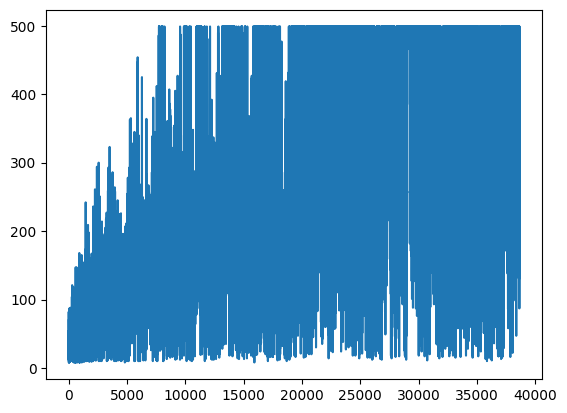

In [ ]:
plt.plot(sarsa.episode_rewards)

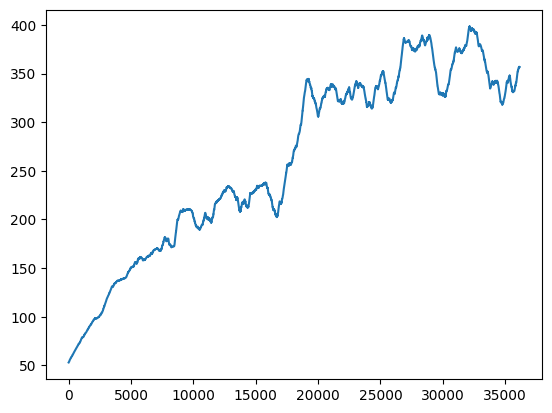

In [ ]:
n = 2500
ma = np.convolve(sarsa.episode_rewards, np.ones(n) / n, 'valid')
plt.plot(ma)

In [ ]:
import pickle

with open('sarsa_400r_30000s.pickle', 'wb') as f:
    pickle.dump(sarsa, f)

In [ ]:
# min_obs, max_obs

(array([-2.4097164 , -3.0748265 , -0.25516647, -2.9667487 ], dtype=float32),
 array([2.4484854 , 3.2317376 , 0.25910497, 3.0691397 ], dtype=float32))

### Q-Learning

In [ ]:
q_learning = QLearning(state_space_bounds, state_space_epsilon, action_space, alpha=0.5, gamma=0.95, greedey_epsilon=0.1)

In [ ]:
q_learning.greedy_epsilon = 0.0

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
observation, info = env.reset()

reward = None

# min_obs = observation
# max_obs = observation

for _ in range(1000000):
    action = q_learning.step(observation, reward)[0]
    observation, reward, terminated, truncated, info = env.step(action)

    # min_obs = np.min(np.array([observation, min_obs]), axis=0)
    # max_obs = np.max(np.array([observation, max_obs]), axis=0)

    if terminated or truncated:
        observation, info = env.reset()
        q_learning.reset_episode()
        reward = None

q_learning.reset_episode(False)
env.close()

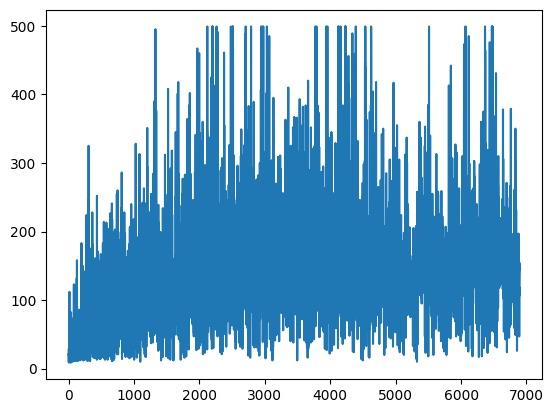

In [ ]:
plt.plot(q_learning.episode_rewards)

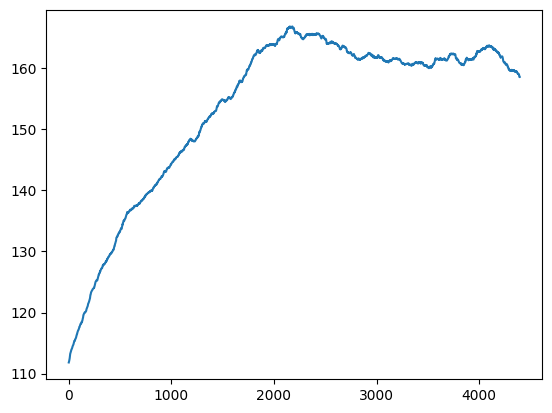

In [ ]:
n = 2500
ma = np.convolve(q_learning.episode_rewards, np.ones(n) / n, 'valid')
plt.plot(ma)

### Sarsa-AGDS

In [14]:
associata.init()

Got message: b'"started"'
Subprocess "vis" started successfully
Got message: b'"started"'
Subprocess "backend" started successfully


In [15]:
sarsa_agds = SarsaAGDS(state_space_feature_names, state_space_bounds, state_space_epsilon, action_space)

In [16]:
env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset(seed=42)

reward = None

for _ in range(200):
    action = sarsa_agds.step(observation, reward)[0]
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()
        sarsa_agds.reset_episode()
        reward = None

sarsa_agds.reset_episode(False)
env.close()


=============== Step 0 ===============
[0s] State: [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
Reward (for prevoius action): None

Best sa: None
[0s] Picked action: [0]

=============== Step 1 ===============
[0s] State: [ 0.02727336 -0.20172954  0.03625453  0.32351476]
Reward (for prevoius action): 1.0

Best sa: None
[0s] Picked action: [1]
Adding observation: {add_observation,#{"x_pos" => 0.02739560417830944, "x_speed" => -0.006112155970185995, "ang_pos" => 0.03585979342460632, "ang_speed" => 0.019736802205443382, "value" => 0.2, "action" => 0}}.

=============== Step 2 ===============
[0s] State: [ 0.02323877 -0.00714208  0.04272482  0.04248186]
Reward (for prevoius action): 1.0

Best sa: 0
Best sa neigh nodes: [('vn', 'x_speed', '-0.006112155970185995'), ('vn', 'x_pos', '0.02739560417830944'), ('vn', 'value', '0.2'), ('vn', 'ang_speed', '0.019736802205443382'), ('vn', 'ang_pos', '0.03585979342460632'), ('vn', 'action', '0')]
[0s] Picked action: [0]
Adding observation: {add_o

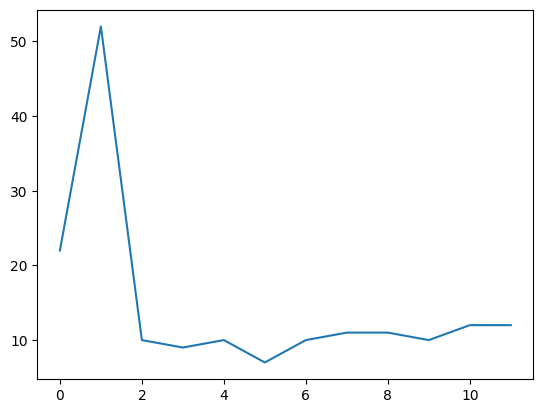

In [17]:
plt.plot(sarsa_agds.episode_rewards)

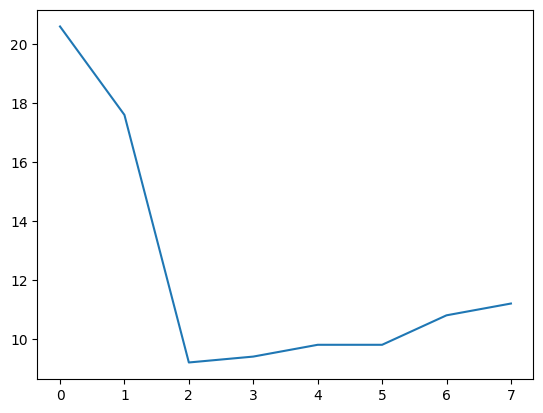

In [18]:
n = 5
ma = np.convolve(sarsa_agds.episode_rewards, np.ones(n) / n, 'valid')
plt.plot(ma)

In [19]:
sarsa_agds.stop()

Got message: b'"structure_stopped"'
Got message: b'"vis_stopped"'


In [20]:
associata.stop()

Subprocess "backend" stopped successfully
Subprocess "vis" stopped successfully
